<h2>                 Predictive Measures for Mitigation of COVID-19 Community Transmission </h2>
<h3>                         Applied Data Science Capstone Project, an effort by Manik Kapil </h3>


<h3> 1. Introduction </h3>

<p> Coronaviruses are family of viruses that cause diseases generally in birds and animals, which in some cases get transmitted to humans, like the one the whole world is currently facing. COVID-19 or Coronavirus Disease 19 is the name WHO (World Health Organization) coined for this new disease which as of 26th April 2020, consumed at least 203,705 lives and more than 2,936,876 confirmed cases.</p><p> IMA (Indian Medical Association) & ICMR (Indian Council of Medical Research) have been on their feet even before the first case was recorded in India, still as we speak there are at least 26.9k active cases and as many as 825 deaths and we are only in 2nd Stage of Transmission.</p><p> Therefore, it is imperative to estimate the existing cluster of cases in the country, investigate the treatment, recovery and deaths in those areas and to explore if there are any predictions can be made for new Quarantine facilities. A large number of daily wage workers suddenly boggled by this situation find themselves without food and shelter. We’ll also try and predict the areas where migrant workers might take food and shelter while maintaining social distancing. </p>
<p> </p>

<h3> 2. Business Problem</h3>

<p> The world has come to a halt amid COVID-19. All economic machineries have come to a standstill and the liquidity in market has dried out. Hence, the breakage of transmission chain and release in economic activity is one following the other. </p>
<p> Every government in the world, every CEO of every company, every worker either daily-wage or salaried, every front-line COVID worker is interested in finding some way that can break the existing transmission chain and slowly the world returns to normalcy. Hence, this project is one aiming that.</p>


<h3> 3. Data </h3>

<p>Since, we're taking the context of India, we'll be looking at Data-sets containing coordinates of Indian States. We will be exploring the latest patient dataset. We'll also be looking at a data-set which will contain the records of Individual Patient updated daily.</p>
<p>To have a better look at ground reality, we will be looking at districts data also.</p>

<h3> 4. Analysis </h3>

<p> Let's start the coding part by importing libraries </p>

In [47]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
!conda install -c conda-forge folium=0.5.0 --yes
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

print("Libaries Imported !")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libaries Imported !


<p> Let's import our data sets and clean as we use them </p>

In [48]:
raw_data_url = 'https://api.covid19india.org/csv/latest/raw_data.csv'
raw_data_df = pd.read_csv(raw_data_url)
raw_data_df.drop(['Source_1','Source_2','Source_3'], 1, inplace = True)

state_wise_url = 'https://api.covid19india.org/csv/latest/state_wise.csv'
state_wise_df = pd.read_csv(state_wise_url)
state_wise_df.drop('State_Notes',1,inplace = True)
state_wise_df.drop(0, inplace = True)
state_wise_df['Confirmed-Norm'] = (state_wise_df['Confirmed']-state_wise_df['Confirmed'].min())/(state_wise_df['Confirmed'].max()-state_wise_df['Confirmed'].min())
state_wise_df.set_index('State', inplace = True)
state_wise_df.reset_index(inplace = True)

state_wise_daily_url = 'https://api.covid19india.org/csv/latest/state_wise_daily.csv'
state_wise_daily_df = pd.read_csv(state_wise_daily_url)

statewise_tested_numbers_data_url = 'https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv'
statewise_tested_numbers_data_df = pd.read_csv(statewise_tested_numbers_data_url)

case_time_series_url = 'https://api.covid19india.org/csv/latest/case_time_series.csv'
case_time_series_df = pd.read_csv(case_time_series_url)

tested_numbers_icmr_data_url = 'https://api.covid19india.org/csv/latest/tested_numbers_icmr_data.csv'
tested_numbers_icmr_data_df = pd.read_csv(tested_numbers_icmr_data_url)
tested_numbers_icmr_data_df['Update Time Stamp'] = tested_numbers_icmr_data_df['Update Time Stamp'].apply(lambda x: x[0:10])
tested_numbers_icmr_data_df['Test positivity rate'] = tested_numbers_icmr_data_df['Test positivity rate'].astype(str) 
tested_numbers_icmr_data_df['Test positivity rate'] = tested_numbers_icmr_data_df['Test positivity rate'].apply(lambda x: x[0:4])
tested_numbers_icmr_data_df['Total Positive Cases'].replace(['12,581'],'12581',inplace = True)
#tested_numbers_icmr_data_df.drop(['Unnamed: 2','Source','Unnamed: 9','Tests conducted by Private Labs','Sample Reported today','Positive cases from samples reported'], 1, inplace = True)
tested_numbers_icmr_data_df['Total Samples Tested'] = tested_numbers_icmr_data_df['Total Samples Tested'].astype(str)
tested_numbers_icmr_data_df= tested_numbers_icmr_data_df[tested_numbers_icmr_data_df['Total Samples Tested']!='nan']
tested_numbers_icmr_data_df['Total Samples Tested'] = tested_numbers_icmr_data_df['Total Samples Tested'].astype(float)
tested_numbers_icmr_data_df['Total Positive Cases'] = tested_numbers_icmr_data_df['Total Positive Cases'].astype(str)
tested_numbers_icmr_data_df = tested_numbers_icmr_data_df[tested_numbers_icmr_data_df['Total Positive Cases'] != 'nan']
tested_numbers_icmr_data_df['Total Positive Cases'] = tested_numbers_icmr_data_df['Total Positive Cases'].astype(float)
tested_numbers_icmr_data_df['Total Individuals Tested'] = tested_numbers_icmr_data_df['Total Individuals Tested'].astype(str)
tested_numbers_icmr_data_df = tested_numbers_icmr_data_df[tested_numbers_icmr_data_df['Total Individuals Tested']!= 'nan']
tested_numbers_icmr_data_df['Total Individuals Tested'] = tested_numbers_icmr_data_df['Total Individuals Tested'].astype(float)
tested_numbers_icmr_data_df['Test positivity rate'] = tested_numbers_icmr_data_df['Test positivity rate'].astype(float)


print('Datasets imported !')

Datasets imported !


In [49]:
indian_coordinates_df = pd.read_csv('Indian Coordinates.csv')
indian_coordinates_df.columns = ['State','Latitude','Longitude']
indian_coordinates_df.sort_values('State', inplace = True)
indian_coordinates_df.set_index('State', inplace = True)
indian_coordinates_df.reset_index(inplace = True)

print('Coordinates Accquired !')

Coordinates Accquired !


<p> Let's make a function that will add Coordinates for states </p>

In [50]:
def assign_coordinates(dataframe):
    dataframe.sort_values('State', inplace = True)
    dataframe['Latitude'] = indian_coordinates_df['Latitude'].values
    dataframe['Longitude'] = indian_coordinates_df['Longitude'].values

    return dataframe

<p> Let's append Latitudes and Longitudes to out State Data, here's how our dataset looks after this step. </p>

In [51]:
state_wise_df = assign_coordinates(state_wise_df)
state_wise_df.head()

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,Confirmed-Norm,Latitude,Longitude
22,Andaman and Nicobar Islands,33,11,0,22,25/04/2020 20:02:39,AN,0,0,0,0.004090,11.667026,92.735983
7,Andhra Pradesh,1097,231,31,835,26/04/2020 11:57:37,AP,81,60,0,0.135969,14.750429,78.570026
31,Arunachal Pradesh,1,1,0,0,16/04/2020 19:33:11,AR,0,0,0,0.000124,27.100399,93.616601
21,Assam,36,27,1,8,26/04/2020 17:32:41,AS,0,8,0,0.004462,26.749981,94.216667
15,Bihar,274,56,2,216,26/04/2020 18:42:43,BR,23,11,0,0.033961,25.785414,87.479973


<p> Let's visualize Total Confirmed Cases across the states </p>

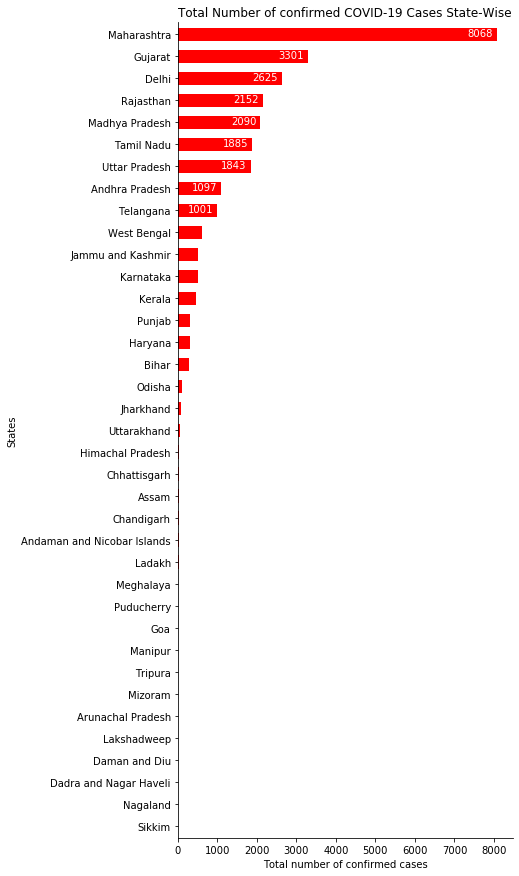

In [52]:
state_wise_df.sort_values(by='Confirmed', inplace = True, ascending = True)
# Let's Look at the Confirmed Cases in all of the states
ax0 = state_wise_df['Confirmed'].plot(kind= 'barh', figsize = (6,15), color = 'r', width = 0.6)
ax0.set_ylabel('States')
ax0.set_yticklabels(state_wise_df.State)
ax0.set_xlabel('Total number of confirmed cases')
ax0.set_title('Total Number of confirmed COVID-19 Cases State-Wise')

for index, val in enumerate(state_wise_df['Confirmed']):
    label = int(val)
    ax0.annotate(label, xy=(val - 750, index - 0.1), color = 'white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

<p> Let's look at Recovered Patients State-Wise </P

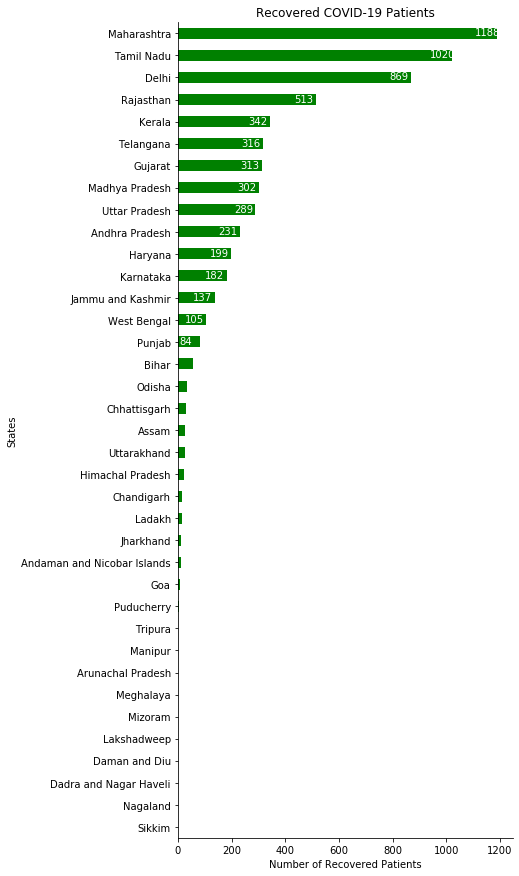

In [53]:
state_wise_df.sort_values(by='Recovered', ascending = True, inplace = True)
ax1 = state_wise_df['Recovered'].plot(kind ='barh', figsize = (6,15), color = 'g')
ax1.set_title('Recovered COVID-19 Patients')
ax1.set_yticklabels(state_wise_df.State)
ax1.set_ylabel('States')
ax1.set_xlabel('Number of Recovered Patients')

for index, val in enumerate(state_wise_df['Recovered']):
    plt.annotate(val, xy=(val-80, index-0.1), color = 'white')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

<p> An important part of our analysis will consist of Active Cases and Deaths</p>
<p> Let's look at Active cases State wise And Also State wise Deaths </p>

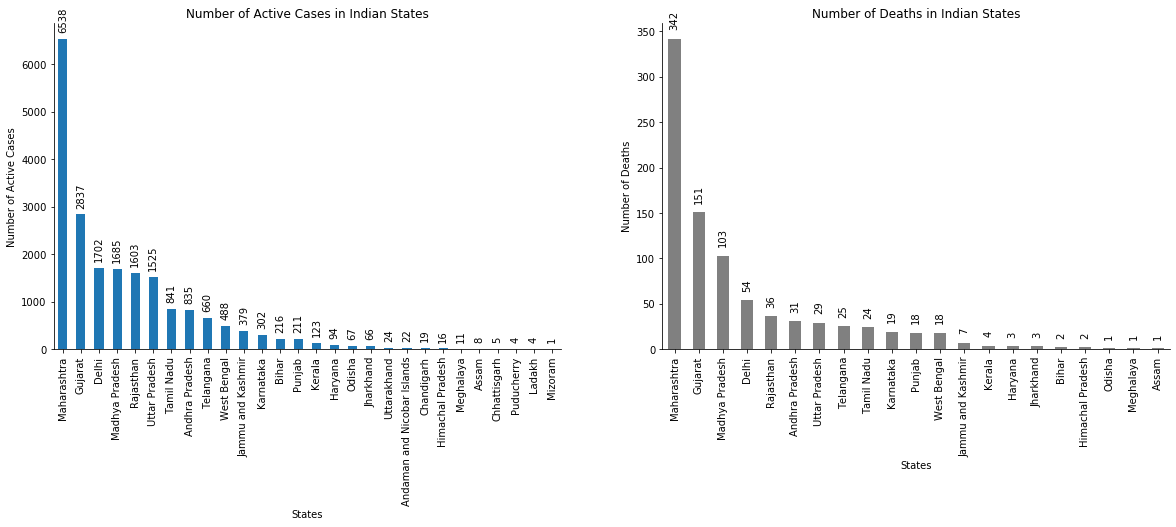

In [61]:
state_wise_df.head()
plt.subplot(121)
state_wise_df.sort_values('Active', inplace = True, ascending = False)
state_wise_df[state_wise_df['Active']>0]['Active'].plot(kind = 'bar', figsize = (20,6), width = 0.5)
plt.gca().set_xlabel('States')
plt.gca().set_xticklabels(state_wise_df[state_wise_df['Active']>0].State)
plt.gca().set_ylabel('Number of Active Cases')
plt.gca().set_title('Number of Active Cases in Indian States')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
rects = plt.gca().patches
# Make some labels.
labels = [i for i in state_wise_df['Active']]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height + 135, label,
            ha='center', va='bottom', rotation = 90)
    
    
plt.subplot(122)
state_wise_df.sort_values('Deaths', inplace = True, ascending = False)
state_wise_df[state_wise_df['Deaths']>0]['Deaths'].plot(kind = 'bar', figsize = (20,6), color = 'gray', width = 0.5)
plt.gca().set_xticklabels(state_wise_df[state_wise_df['Deaths']>0].State)
plt.gca().set_title('Number of Deaths in Indian States')
plt.gca().set_xlabel('States')
plt.gca().set_ylabel('Number of Deaths')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
rectas = plt.gca().patches
# Make some labels.
labals = [x for x in state_wise_df['Deaths']]

for rect, label in zip(rectas, labals):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom', rotation = 90)

<p> Government of India imposed Complete Country lockdowns in two phases:<br/>
    First, from <b>March 25 to April 14 2020</b>,<br/>
    Second, from <b>April 15 to 3rd May 2020</b>.<br/>
    Let's analyse the effect of these lockdowns on daily number of cases :</p>

In [62]:
def toDate(string):
    parts = string.split(' ')
    datetime_object = datetime.datetime.strptime(parts[1], "%B")
    parts[1] = datetime_object.month
    newString = str(parts[0])+'-'+str(parts[1])+'-'+'2020'
    return(newString)
    
case_time_series_df['Date'] = case_time_series_df['Date'].apply(toDate, 1) 
pd.to_datetime(case_time_series_df.Date)
case_time_series_df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30-1-2020,1,1,0,0,0,0
1,31-1-2020,0,1,0,0,0,0
2,01-2-2020,0,1,0,0,0,0
3,02-2-2020,1,2,0,0,0,0
4,03-2-2020,1,3,0,0,0,0


<p> Let's visualize the Daily number of Confirmed cases, Daily Recovered Cases And Daily Deaths </p>

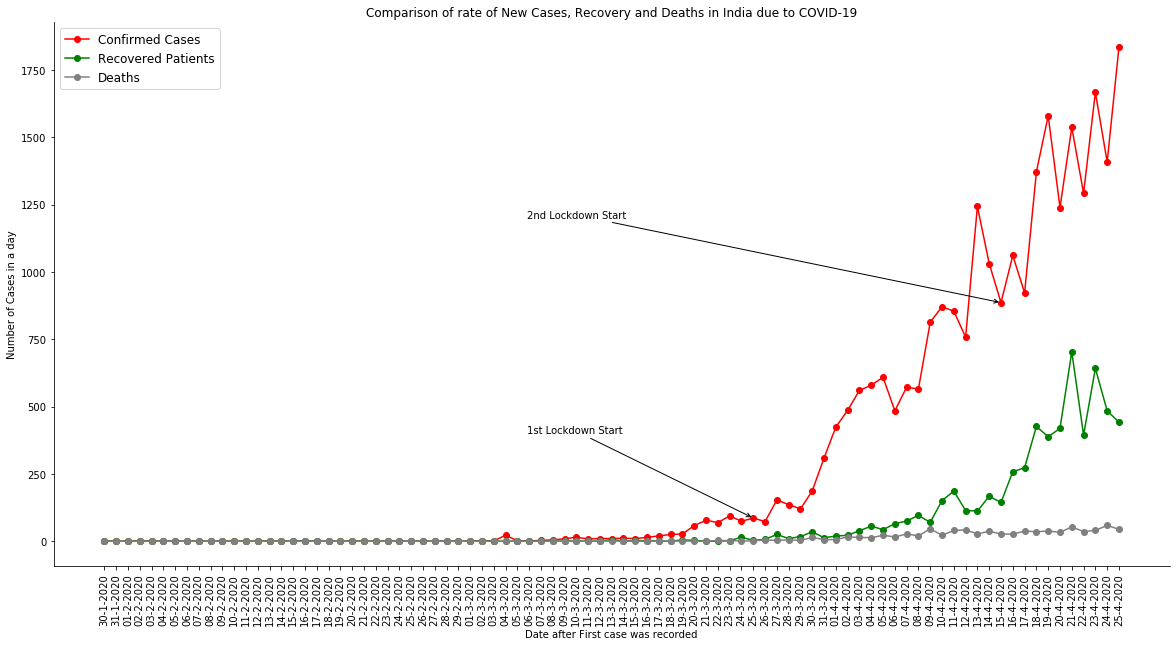

In [63]:
plt.figure(figsize = (20,10))
plt.plot(case_time_series_df.Date,case_time_series_df['Daily Confirmed'], color = 'red', label = 'Confirmed Cases', marker = 'o')
plt.plot(case_time_series_df.Date,case_time_series_df['Daily Recovered'], color = 'green', label = 'Recovered Patients', marker = 'o')
plt.plot(case_time_series_df.Date,case_time_series_df['Daily Deceased'], color = 'gray', label = 'Deaths', marker = 'o')
plt.xlabel('Date after First case was recorded')
plt.ylabel('Number of Cases in a day')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_title('Comparison of rate of New Cases, Recovery and Deaths in India due to COVID-19')
plt.legend(fontsize = 12)
plt.gca().set_xticklabels(case_time_series_df.Date, rotation = 90)

plt.annotate(
    '1st Lockdown Start', xy=(case_time_series_df.Date[55],case_time_series_df['Daily Confirmed'][55]), xytext = (35.8,400), xycoords = 'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3")
)
plt.annotate(
    '2nd Lockdown Start', xy=(case_time_series_df.Date[76],case_time_series_df['Daily Confirmed'][76]), xytext = (35.8,1200),xycoords = 'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3")
)
plt.show()

<p>Hence, we can conclude that, though the cases have been on a rise, we observe that early lockdown still someshow managed to control the daily number of cases to maximum of 1800. Hence, we observe a controlled situation still before <b>Community Transmission.</b></p>
<p>The reason behind the climb in daily number of cases after first lockdown can somewhat be attributed to <i>Tabligi Jamaat</i> incident, in Delhi at least. Also, there have been limited testing all throughout the country hence, we observed a rise in cases.</p>
<p>To get a better picture let's visualize the situation on Indian Subcontitent Map</p>

In [64]:
india_map = folium.Map([26.84,80.94], zoom_start = 5)
india_map
for state, con, conorm, lat, long in zip(state_wise_df['State'],state_wise_df['Confirmed'],state_wise_df['Confirmed-Norm'],state_wise_df['Latitude'],state_wise_df['Longitude']):
    label = '{} : {}'.format(state, con)
    folium.CircleMarker(
    [lat, long],
    fill = True,
    fill_color = 'dark red',
    radius = conorm*60+2,
    popup = label).add_to(india_map)    
india_map

<p> We just observed the severity of cases in states as shown by the radius of circular markers. </p>


<p> To actually see, if India entered in <b>Community Transmission</b> stage, we need to see the daily positive percentage of daily tests </p>

<p> Let's visualize this through a plot </p>

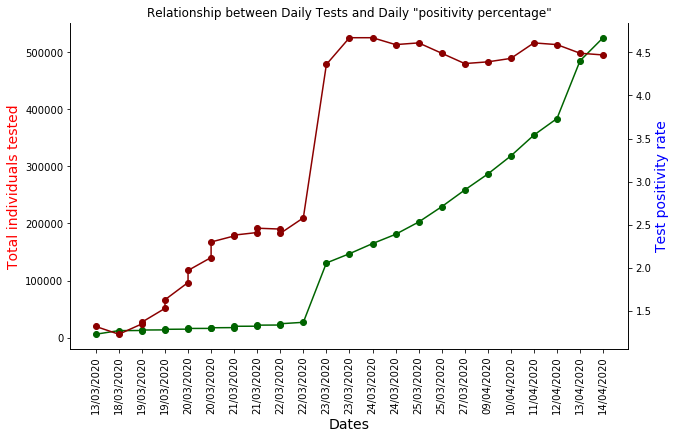

In [13]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(tested_numbers_icmr_data_df['Update Time Stamp'], tested_numbers_icmr_data_df['Total Individuals Tested'], color="darkgreen", marker="o")
ax.set_xlabel("Dates",fontsize=14)
ax.set_ylabel("Total individuals tested",color="red",fontsize=14)
plt.gca().spines['top'].set_visible(False)


ax2=ax.twinx()
ax2.plot(tested_numbers_icmr_data_df['Update Time Stamp'], tested_numbers_icmr_data_df['Test positivity rate'], color="darkred", marker="o")
ax2.set_ylabel("Test positivity rate",color="blue",fontsize=14)
plt.gca().spines['top'].set_visible(False)

ax.set_xticklabels(labels = tested_numbers_icmr_data_df['Update Time Stamp'],rotation = 90)
ax.set_title('Relationship between Daily Tests and Daily "positivity percentage"')
plt.show()

<p> Now, let's dig deeper and look at district level situation to take our analysis further. </p>

In [65]:
import urllib, json
from pandas.io.json import json_normalize
url = 'https://api.covid19india.org/v2/state_district_wise.json'
results = requests.get(url).json()
state_names = []
for i in range(len(results)):
    state_names.append(results[i]['state'])

<p> Let's create a function to breakdown the districtData column in further DataFrame </p>

In [66]:
def get_district_dataframe(state_name):
    
    districts_list = []
    for name, i in zip(state_name, np.arange(len(state_name))):
        res = requests.get(url).json()[i]['districtData']
        districts_list.append([(
            name,
            v['district'],
            v['active'],
            v['confirmed'],
            v['recovered']) for v in res])
                
        districts_df = pd.DataFrame([item for district_list in districts_list for item in district_list])
        districts_df.columns = ['State','District','Active','Confirmed','Recovered']
        
    
    return districts_df

In [67]:
district_status_df = get_district_dataframe(state_names)
district_status_df.head()

,State,District,Active,Confirmed,Recovered
0,Andaman and Nicobar Islands,North and Middle Andaman,0,1,1
1,Andaman and Nicobar Islands,South Andaman,22,32,10
2,Andhra Pradesh,Anantapur,35,53,14
3,Andhra Pradesh,Chittoor,60,73,13
4,Andhra Pradesh,East Godavari,27,39,12


<p> This is the required Data Frame </p>
<p> Now, we will do our further analysis with this Data Frame only </p>
<p> The issue of identifying severely COVID-19 infected districts for enhanced containment efforts is so critical that we should not overlook even a single district that requires additional assistance.</p>

<p> Government of India, defined those districts as<b> Red Zones which have more than six cases.</b> </p>
<p> So, let's look at those districts for now. <p>

In [70]:
covid_districts = district_status_df[district_status_df['Confirmed'] > 6]
print("Hence there are {} districts which are currently labelled as COVID-19 Hotspots in India".format(covid_districts.shape[0]))
covid_districts.head()

Hence there are 269 districts which are currently labelled as COVID-19 Hotspots in India


,State,District,Active,Confirmed,Recovered
1,Andaman and Nicobar Islands,South Andaman,22,32,10
2,Andhra Pradesh,Anantapur,35,53,14
3,Andhra Pradesh,Chittoor,60,73,13
4,Andhra Pradesh,East Godavari,27,39,12
5,Andhra Pradesh,Guntur,177,214,29


<p> Let's define a function that will fetch the Latitudes and Longitudes of Districts. It is going to use GeoPy Geolocator</p>

In [71]:
def get_latitude(string):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(string)
    if location is None:
        return(28.7041)
    else:
        latitude = location.latitude
        return(latitude)
    latitude = location.latitude
    return(latitude)

In [72]:
def get_longitude(string):
    address = str(string)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location is None:
        return(77.1025)
    else:
        longitude = location.longitude
        return(longitude)

<p> Let's assign these values to our dataframe </p>

In [73]:
covid_districts.loc[:,'Latitude'] = [28.7041 if x=='Unknown' else get_latitude(x) for x in covid_districts['District']]
covid_districts.loc[:,'Longitude'] = [77.1025 if x=='Unknown' else get_longitude(x) for x in covid_districts['District']]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<p> Let's create another column for Normalized values of Confirmed cases </p>

In [74]:
covid_districts['Confirmed Normalized'] = (covid_districts['Confirmed'] - covid_districts['Confirmed'].min())/(covid_districts['Confirmed'].max()-covid_districts['Confirmed'].min())

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<p> Now, we its time to cluster these districts to provide Recommendations for Quarantine Facilites and Testing Facilities </p>

<h3> 5. Clustering </h3>

In [75]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
columns_for_clustering = ['Confirmed Normalized','Latitude','Longitude']
X = covid_districts[columns_for_clustering]
X_norm = scale.fit(X).transform(X)

<p> Here, we are employing the use of K-Means Clustering algorithm to divide our COVID hotpot districts into clusters and assign them into cluster number </p>

In [76]:
from sklearn.cluster import KMeans
number_of_clusters = 100
kmeans = KMeans(init = 'k-means++', n_init = 12, n_clusters = number_of_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
kmeans.labels_

array([15, 77,  4, 19, 97, 97, 10, 58, 53, 60, 19, 27, 22, 85,  9, 87,  9,
       85, 33, 33,  9, 87,  8, 49, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 67, 80, 19, 11, 80, 42, 42, 53, 67, 67, 30, 29, 30, 11, 90,
        2, 80,  8, 53, 53, 53, 99,  8, 16, 16,  5,  8, 47, 13, 13, 53, 13,
       13, 62, 13, 13, 13, 62, 37, 37, 26, 77, 83, 38, 38, 23, 38, 40, 83,
       69, 73, 73, 18, 26, 66, 66, 40, 40, 89, 66, 17, 17, 88, 66, 89, 17,
       52, 14, 54, 29, 50, 50, 29, 50, 57, 96, 96, 14, 82, 29, 91, 50, 29,
       64, 75, 75, 64,  0, 54, 78,  0, 76, 94, 95, 39, 54, 25, 25, 41, 49,
       41, 76, 41, 41, 25, 72,  1, 46, 32, 32, 32, 32, 45, 62, 36, 36, 36,
       93, 62, 93, 36, 53, 51, 68, 30, 68, 92, 81, 21, 68, 98, 34, 43, 14,
       21, 74, 34, 51, 34, 34, 20, 86, 86, 88, 45, 12, 35, 86, 89, 35, 12,
       59, 35, 59, 12,  4,  6, 12, 44, 59, 88, 12, 86, 59, 44, 59, 44,  4,
       88,  4,  4, 45, 12, 72, 79, 10, 56, 28, 71, 69, 79, 71, 56, 55, 86,
       56, 71, 69, 28, 53

In [78]:
covid_districts['Cluster Number'] = kmeans.labels_

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
covid_districts[['Latitude','Longitude']] = covid_districts[['Latitude','Longitude']].apply(np.absolute)
covid_districts.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,State,District,Active,Confirmed,Recovered,Latitude,Longitude,Confirmed Normalized,Cluster Number
1,Andaman and Nicobar Islands,South Andaman,22,32,10,10.705690,92.487468,0.004630,15
2,Andhra Pradesh,Anantapur,35,53,14,14.654623,77.556260,0.008519,77
3,Andhra Pradesh,Chittoor,60,73,13,13.160105,79.155551,0.012222,4
4,Andhra Pradesh,East Godavari,27,39,12,17.233496,81.722599,0.005926,19
5,Andhra Pradesh,Guntur,177,214,29,16.291519,80.454159,0.038333,97


In [80]:
covid_districts['Latitude'] = covid_districts.loc[:,'Latitude'].replace([40.446495,28.797528,40.223109,43.439170,37.526960,51.455268,44.939157],[14.5767,28.464615,31.4685,17.9104,18.938771,26.916194,11.6643])
covid_districts['Longitude'] = covid_districts.loc[:,'Longitude'].replace([74.385983,52.514861,1.977556,1.589891,79.197150,2.589844,123.033121],[78.8383,77.029919,76.2708,77.5199,72.835335,75.820349,78.1460])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<p> Let's visualize these clusters on a Map to have a better view of the situation </p>

In [81]:
indian_covid_districts_map = folium.Map([26.84,80.94], zoom_start = 5)
indian_covid_districts_map

for dis, lat, long, con, connorm, clus in zip(covid_districts['District'],covid_districts['Latitude'],covid_districts['Longitude'],covid_districts['Confirmed'],covid_districts['Confirmed Normalized'],covid_districts['Cluster Number']):
    label = '{}, Cluster Number: {}'.format(dis, clus)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius = connorm*50,
        popup = label,
        fill_color = 'red',
        color = 'red',
        fill = True
    ).add_to(indian_covid_districts_map)

In [82]:
indian_covid_districts_map

<p> So far, we successfully identified the COVID-19 clusters across Indian Districts and we can see the severity of situation by radius of circlular marker.</p>
<p> Now, Let's provide <i>Relief</i> by identifying various venues like areas which can be used as<b> Quarantine Centers</b>, or places where food can be cooked and provided to needy amid these fluid times </p>

<p> Now, we will be looking for centroids of each cluster, and we will do that by taking the mean of our cluster data </p>

In [83]:
cluster_df = covid_districts.groupby('Cluster Number').mean()
cluster_df.head()

,Active,Confirmed,Recovered,Latitude,Longitude,Confirmed Normalized
Cluster Number,,,,,,
0,10.0,20.0,7.5,20.652428,75.811073,0.002407
1,23.0,25.0,0.0,37.526960,79.197150,0.003333
2,495.0,526.0,16.0,45.938300,3.255300,0.096111
3,212.0,227.0,10.5,27.176311,78.199864,0.040741
4,30.0,32.6,2.6,12.712540,79.022453,0.004741


<p> Now, we will make use of FourSquare API to get a better view of areas around these Clusters </p>

#### Define Foursquare Credentials and Version

In [84]:
CLIENT_ID = 'RDOXA1C4LE021ZHZ3JU3GHWR320PP2OZ2EH4TCWL3IJBVZNB'
CLIENT_SECRET = '1Q3XAJZDQIZZQ3K0TFWW2HSCR32OFZK224CHYLDB3HNX5EXD'
VERSION = '20200425'
RADIUS = 50000
LIMIT = 100

print('Credentials Loaded !')

Credentials Loaded !


<p> Let's define a url to access FourSquare API service, we are exploring the neighbors for Delhi, which is cluster number 53 </p>

In [86]:
four_square_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, cluster_df['Latitude'][53], cluster_df['Longitude'][53], VERSION, RADIUS, LIMIT)
four_square_url

'https://api.foursquare.com/v2/venues/explore?client_id=RDOXA1C4LE021ZHZ3JU3GHWR320PP2OZ2EH4TCWL3IJBVZNB&client_secret=1Q3XAJZDQIZZQ3K0TFWW2HSCR32OFZK224CHYLDB3HNX5EXD&ll=28.62698831666667,77.19010129977393&v=20200425&radius=50000&limit=100'

In [87]:
results_four_square = requests.get(four_square_url).json()

<p> Let us write a function to get the category of venue properly </p>

In [88]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [89]:
venues = results_four_square['response']['groups'][0]['items']
imp_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.address','venue.location.city']
imp_venues = imp_venues.loc[:, filtered_columns]
imp_venues['venue.categories'] = imp_venues.apply(get_category_type, axis=1)
imp_venues.columns = [col.split(".")[-1] for col in imp_venues.columns]
imp_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng,address,city
0,The Imperial,Hotel,28.625548,77.218664,Janpath,New Delhi
1,Tamra,Restaurant,28.620543,77.218174,"19, Ashoka Rd",New Delhi
2,Pandey Paan,Smoke Shop,28.622249,77.201075,"Shop No 3, North Avenue",New Delhi
3,Amour Bistro,Café,28.601569,77.185923,Malcha Marg,NaN
4,Lantern's,Bar,28.643183,77.177746,NaN,New Delhi


<p> Now, let's assume that a nearby <i>Hotels, Schools, Colleges</i> can be used as a <b>quarantine</b> facility and a <i>Restaurant</i> can be used as a <b>Community Kitchen</b> under <i>Extreme</i> situations.</p>
<p> Let us filter out the results we have so far, so that we get only these categories, of course we will be including all <b>Hospitals</b> and <i>Medical Facilities</i> </p>

In [90]:
imp_venues = imp_venues[imp_venues['categories'].str.contains('Restaurant|Hotel|School|College|Hospital|Dispensary|Chemist')]
imp_venues.head()

,name,categories,lat,lng,address,city
0,The Imperial,Hotel,28.625548,77.218664,Janpath,New Delhi
1,Tamra,Restaurant,28.620543,77.218174,"19, Ashoka Rd",New Delhi
6,The Big Chill Cafe,Italian Restaurant,28.600686,77.227636,68A,New Delhi
7,The Leela Palace,Hotel,28.579923,77.189291,"Chanakyapuri, Diplomatic Enclave",New Delhi
8,Varq | वर्क,Indian Restaurant,28.604547,77.223781,"Taj Mahal Hotel, Lower Lobby Level",New Delhi


<p> Let's visualize these venues around our Cluster Center, we can see the proximity of these venues with the help of a visualization: </p>

In [92]:
important_places_map = folium.Map([cluster_df['Latitude'][53], cluster_df['Longitude'][53]], zoom_start = 12)

folium.Marker(
    
[cluster_df['Latitude'][53], cluster_df['Longitude'][53]], 
).add_to(important_places_map)

for name, cat, lat, long in zip(imp_venues['name'], imp_venues['categories'],imp_venues['lat'],imp_venues['lng']):
    label = '{},{}'.format(name, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat,long],
        radius = 15,
        color='blue',
        fill=True,
        popup = label,
        fill_color='#3186cc',
        fill_opacity=0.7
            ).add_to(important_places_map)
important_places_map

<p> Hence, we were able to identify the close proximity areas that can be used as<b> relief centers</b> in case of emergency. </p>
<p> This analysis is not the exact ideal solution since the exact coordinates and patient data was not properly uploaded but is really close to it, also if god forbid, situation worsens and this will be the actual scenario to be implemented </p>

<p> I hope you followed along the process and enjoyed the analysis. Thanks ! </p>
